Load data

In [1]:
import pandas as pd
import string
import regex as re
import seaborn as sns

In [2]:
# test1 = pd.read_csv('dataset/books1.csv')
# test2 = pd.read_csv('dataset/books2.csv')
# test = pd.concat([test1, test2], ignore_index=True, sort=False)
# len(test['category'].unique().tolist())

In [3]:
books = pd.read_csv('dataset/book_saved.csv')
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8702 entries, 0 to 8701
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              8702 non-null   object 
 1   author             3003 non-null   object 
 2   google_id          8608 non-null   object 
 3   recommender        3003 non-null   object 
 4   recommender_count  8702 non-null   int64  
 5   publication_date   2898 non-null   object 
 6   pages              2814 non-null   float64
 7   image              5699 non-null   object 
 8   url_image          5699 non-null   object 
 9   target_class       8702 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 680.0+ KB


In [4]:
books[['title', 'target_class']][books['target_class'] == 'sains-tech']

,title,target_class
5,100 Plus,sains-tech
6,12 Rules for Life,sains-tech
8,13 Things That Don't Make Sense,sains-tech
19,59 Seconds,sains-tech
23,A Brief History of Time,sains-tech
...,...,...
8608,Porsche 917 Owners' Workshop Manual 1969 onwar...,sains-tech
8614,"Maximum Boost: Designing, Testing and Installi...",sains-tech
8648,2014 Architecture Wall Calendar,sains-tech
8656,NeuroTribes: The Legacy of Autism and the Futu...,sains-tech


Exploration

In [5]:
books = books[~books.duplicated(subset=['title'])]
books = books[['title', 'recommender_count', 'target_class']]

In [6]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8648 entries, 0 to 8701
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   title              8648 non-null   object
 1   recommender_count  8648 non-null   int64 
 2   target_class       8648 non-null   object
dtypes: int64(1), object(2)
memory usage: 270.2+ KB


Data Preprocessing

In [7]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
# merubah menjadi lowercase
def casefolding(text): 
    return text.casefold()

# menghilangkan karakter yang tidak berfungsi dan angka pada teks
def removeCharNumber(text):
    for i in string.punctuation:
        text = text.replace('{}'.format(i), '')
    if text.isnumeric():
        return text
    else:
        return ''.join(i for i in text if not i.isdigit())
    
# menghitung stopword dan menghilangkannya serta tokenisasi teks dalam kata berdasarkan pembatas
def word_token(text:str):
    stopWords = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    arrays = [w for w in word_tokens if w not in stopWords]
    return arrays


# normalisasi teks untuk menjaga kosa kata, menghilangkan kata tidak jelas, dan meningkatkan akurasi kata
def lemmatizing(word):
    wnl = WordNetLemmatizer()
    return ' '.join([wnl.lemmatize(words) for words in word])

# memisahkan kata menjadi bentuk list
def splitter(text):
    return text.split()


In [9]:
containers = []
for title in books['title']:
    title = casefolding(title)
    title = removeCharNumber(title)
    title = word_token(title)
    title = lemmatizing(title)
    title = splitter(title)
    containers.append(title)
books['title_preprocessing'] = containers
books['text_cleaning'] = books['title_preprocessing'].apply(lambda x: ' '.join(x))

In [10]:
books = books[books['text_cleaning'] != '']
books = books[['title','text_cleaning',  'title_preprocessing','target_class']]

In [11]:
books.head()

,title,text_cleaning,title_preprocessing,target_class
0,"Surely You're Joking, Mr. Feynman!",surely youre joking mr feynman,"[surely, youre, joking, mr, feynman]",general
1,What Do You Care What Other People Think?,care people think,"[care, people, think]",general
2,10% Happier,happier,[happier],general
3,100 Best-Loved Poems,bestloved poem,"[bestloved, poem]",general
4,100 Great Operas And Their Stories,great opera story,"[great, opera, story]",general


In [12]:
books.to_csv('dataset/preprocessing.csv', sep=';', encoding='utf-8', index=False)

In [13]:
df = pd.read_csv('dataset/preprocessing.csv', sep=';')

c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'count')

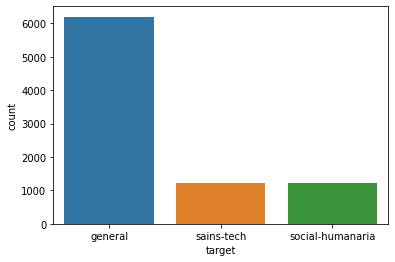

In [14]:
sns.countplot(df.target_class)
plt.xlabel('target')
plt.ylabel('count')

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
import json
from sklearn.svm import SVC
import numpy as np

In [16]:
le = LabelEncoder()
labels = le.fit_transform(df['target_class'].values)
labels

array([0, 0, 0, ..., 0, 0, 0])

In [17]:
keyValues = {int(labels[i]) :le.inverse_transform(labels)[i] for i in range(len(le.inverse_transform(labels)))}
keyValues

{0: 'general', 1: 'sains-tech', 2: 'social-humanaria'}

In [18]:
with open('result/labeling.json', 'w', encoding='utf-8') as output:
    dump = json.dumps(keyValues)
    output.write(dump)

In [19]:
df.target_class.value_counts()/np.float(len(df))

general             0.718073
sains-tech          0.141021
social-humanaria    0.140905
Name: target_class, dtype: float64

proof about cosine similarity

In [20]:
df

,title,text_cleaning,title_preprocessing,target_class
0,"Surely You're Joking, Mr. Feynman!",surely youre joking mr feynman,"['surely', 'youre', 'joking', 'mr', 'feynman']",general
1,What Do You Care What Other People Think?,care people think,"['care', 'people', 'think']",general
2,10% Happier,happier,['happier'],general
3,100 Best-Loved Poems,bestloved poem,"['bestloved', 'poem']",general
4,100 Great Operas And Their Stories,great opera story,"['great', 'opera', 'story']",general
...,...,...,...,...
8632,Scandalous Behavior (A Stone Barrington Novel),scandalous behavior stone barrington novel,"['scandalous', 'behavior', 'stone', 'barringto...",general
8633,Age of Distraction: The Island,age distraction island,"['age', 'distraction', 'island']",sains-tech
8634,The Ghostly Quilts on Main (Colebridge Communi...,ghostly quilt main colebridge community,"['ghostly', 'quilt', 'main', 'colebridge', 'co...",general
8635,Saving Jason (A Jason Stafford Novel),saving jason jason stafford novel,"['saving', 'jason', 'jason', 'stafford', 'novel']",general


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(
        min_df=1,  # min count for relevant vocabulary
        strip_accents='unicode',  # replace all accented unicode char 
        # by their corresponding  ASCII char
        analyzer='word',  # features made of words
        token_pattern=r'\w{1,}',  # tokenize only words of 4+ chars
        ngram_range=(1, 1),  # features made of a single tokens
        use_idf=True,  # enable inverse-document-frequency reweighting
        smooth_idf=True,  # prevents zero division for unseen words
        sublinear_tf=False
    )
sparse = tfidf.fit_transform(df.text_cleaning.values.tolist())
print(sparse)


  (0, 3542)	0.4174952675479513
  (0, 6440)	0.406845433847043
  (0, 5153)	0.4973184530513057
  (0, 10732)	0.406845433847043
  (0, 9424)	0.4973184530513057
  (1, 9688)	0.6318529496341289
  (1, 7224)	0.5343513489430802
  (1, 1437)	0.5614539036478075
  (2, 4302)	1.0
  (3, 7434)	0.6021847675629504
  (3, 922)	0.7983567534098748
  (4, 9278)	0.41904702870970717
  (4, 6892)	0.7530716730270911
  (4, 4129)	0.5072303648380526
  (5, 7423)	1.0
  (6, 5547)	0.5583399178271121
  (6, 8347)	0.8296122806231918
  (7, 5092)	0.4630422241041315
  (7, 3659)	0.6094633225232715
  (7, 9062)	0.5279852440176535
  (7, 8570)	0.3679374121983425
  (8, 8640)	0.5683717937613945
  (8, 5827)	0.45208937461502535
  (8, 2779)	0.5268015448300256
  (8, 9687)	0.44164333322416266
  :	:
  (8631, 6519)	0.3471115423814571
  (8631, 8706)	0.197979236775495
  (8632, 777)	0.5381179267468512
  (8632, 8481)	0.5148340525549449
  (8632, 877)	0.4306295004246369
  (8632, 6749)	0.30852085348445074
  (8632, 9267)	0.4058917485891731
  (8633, 271

In [22]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

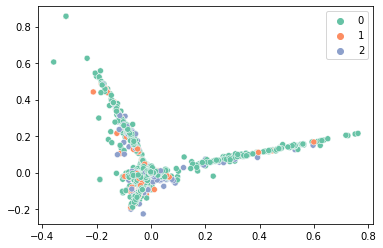

In [23]:
pca = PCA(n_components=2)
name_of_vector_array = sparse.toarray()
x_pca = pca.fit_transform(name_of_vector_array)
sns.scatterplot(x_pca[:, 0], x_pca[:, 1], hue=labels, legend='full', palette='Set2')

In [24]:
table = pd.DataFrame(sparse.toarray(), index=df.title.values.tolist(), columns=tfidf.get_feature_names())
table.head()

c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,1944,1984,531,a,aaa,aacc,ab,abandoned,abandoning,abandonment,...,zoo,zoonosi,zorba,zoroaster,zoroastrian,zoroastrianism,zoroastro,zozzy,zucked,zx
"Surely You're Joking, Mr. Feynman!",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
What Do You Care What Other People Think?,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10% Happier,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100 Best-Loved Poems,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100 Great Operas And Their Stories,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
similarity_scores = cosine_similarity(table)
similarity_scores

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [33]:
def recommend(book):
    array = []
    book_index = np.where(table.index == book)[0][0]
    distances = similarity_scores[book_index]
    book_list = sorted(list(enumerate(distances)),reverse=True,key=lambda x:x[1])
    
    for i in book_list:
        obj = {}
        obj['akurasi'] = i[1]
        obj['title'] = table.index[i[0]]
        obj['label'] = df[df['title'] == table.index[i[0]]]['target_class'].values.tolist()[0]
        array.append(obj)
    return array
array = recommend("Chemistry: Concepts & Applications, Student Edition")
array

[{'akurasi': 1.0,
  'title': 'Chemistry: Concepts & Applications, Student Edition',
  'label': 'sains-tech'},
 {'akurasi': 0.5188934782218979,
  'title': 'Theories of Development: Concepts and Applications',
  'label': 'sains-tech'},
 {'akurasi': 0.3613986761310829,
  'title': 'Organic Chemistry (7th Edition)',
  'label': 'sains-tech'},
 {'akurasi': 0.33401286560476195,
  'title': 'The Continuum Concept',
  'label': 'general'},
 {'akurasi': 0.3339229273423565,
  'title': 'Supramolecular Chemistry: From Biological Inspiration to Biomedical Applications',
  'label': 'sains-tech'},
 {'akurasi': 0.3276038555510807,
  'title': 'E-Commerce Concepts',
  'label': 'social-humanaria'},
 {'akurasi': 0.31039003548906435,
  'title': 'Culinary Essentials, Student Edition',
  'label': 'general'},
 {'akurasi': 0.30272367609253165,
  'title': 'Glencoe Health, Student Edition',
  'label': 'sains-tech'},
 {'akurasi': 0.3022676059473113,
  'title': 'Civics in Practice: Student Edition 2009',
  'label': 'g

In [36]:
def fun(variable):
    array_akurasi = []
    letters = ['A History of Civilizations', 'A River Runs Through It']
    if (variable['title'] in letters):
        array_akurasi.append(variable['akurasi'])
        return array_akurasi
filtered = filter(fun, array)
for s in filtered:
    print(s)

{'akurasi': 0.0, 'title': 'A History of Civilizations', 'label': 'social-humanaria'}
{'akurasi': 0.0, 'title': 'A River Runs Through It', 'label': 'general'}


In [37]:
import matplotlib.pyplot as plt 

Training - test model

In [38]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.multiclass import OneVsOneClassifier

In [39]:
x_train, x_test, y_train, y_test = train_test_split(df['text_cleaning'].values.tolist(), df['target_class'], test_size=0.25)

cosine_similarity kernels

In [40]:
model = make_pipeline(
        TfidfVectorizer(
        min_df=1,  # min count for relevant vocabulary
        strip_accents='unicode',  # replace all accented unicode char 
        # by their corresponding  ASCII char
        analyzer='word',  # features made of words
        token_pattern=r'\w{1,}',  # tokenize only words of 4+ chars
        ngram_range=(1, 1),  # features made of a single tokens
        use_idf=True,  # enable inverse-document-frequency reweighting
        smooth_idf=True,  # prevents zero division for unseen words
        sublinear_tf=False
    ),
    SVC(kernel=cosine_similarity, C=1)
)
model.fit(x_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(strip_accents='unicode',
                                 token_pattern='\\w{1,}')),
                ('svc',
                 SVC(C=1,
                     kernel=<function cosine_similarity at 0x000001DD6CE90048>))])

In [41]:
y_pred_test = model.predict(x_test)
print(model.score(x_train, y_train))
print(model.score(x_test, y_test))
print('model accuracy score with cosine similarity: {0} -> {1}'.format(accuracy_score(y_test, y_pred_test), y_pred_test))

0.9499768411301528
0.8981481481481481
model accuracy score with cosine similarity: 0.8981481481481481 -> ['social-humanaria' 'general' 'general' ... 'general' 'general'
 'sains-tech']


In [42]:
print('classification report for C=1\n', classification_report(y_test, y_pred_test, target_names=['sains-tech', 'social-humanaria', 'general']))

classification report for C=1
                   precision    recall  f1-score   support

      sains-tech       0.89      0.99      0.94      1528
social-humanaria       0.95      0.55      0.70       323
         general       0.94      0.78      0.86       309

        accuracy                           0.90      2160
       macro avg       0.92      0.78      0.83      2160
    weighted avg       0.90      0.90      0.89      2160



In [43]:
# C kecil
model_value_min = make_pipeline(
        TfidfVectorizer(
        min_df=1,  # min count for relevant vocabulary
        strip_accents='unicode',  # replace all accented unicode char 
        # by their corresponding  ASCII char
        analyzer='word',  # features made of words
        token_pattern=r'\w{1,}',  # tokenize only words of 4+ chars
        ngram_range=(1, 1),  # features made of a single tokens
        use_idf=True,  # enable inverse-document-frequency reweighting
        smooth_idf=True,  # prevents zero division for unseen words
        sublinear_tf=False
    ),
    SVC(kernel=cosine_similarity, C=0.05)
)
model_value_min.fit(x_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(strip_accents='unicode',
                                 token_pattern='\\w{1,}')),
                ('svc',
                 SVC(C=0.05,
                     kernel=<function cosine_similarity at 0x000001DD6CE90048>))])

In [44]:
y_pred_test_model_min = model_value_min.predict(x_test)
print('model accuracy score with cosine similarity: {0} -> {1}'.format(accuracy_score(y_test, y_pred_test_model_min), y_pred_test_model_min))

model accuracy score with cosine similarity: 0.7152777777777778 -> ['social-humanaria' 'general' 'general' ... 'general' 'general' 'general']


In [45]:
print('classification report for C=0.05\n', classification_report(y_test, y_pred_test_model_min, target_names=['sains-tech', 'social-humanaria', 'general']))

classification report for C=0.05
                   precision    recall  f1-score   support

      sains-tech       0.71      1.00      0.83      1528
social-humanaria       0.00      0.00      0.00       323
         general       1.00      0.06      0.10       309

        accuracy                           0.72      2160
       macro avg       0.57      0.35      0.31      2160
    weighted avg       0.65      0.72      0.60      2160



c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Evaluation model with Pipeline

In [46]:
text = ['Chemistry: Concepts & Applications, Student Edition']
text_pred = model.predict(text)
text_pred

array(['sains-tech'], dtype=object)

In [ ]:
import pickle5 as pickle

In [ ]:
pickle.dump(model, open('result/model.pkl', 'wb'))

In [ ]:
load_model = pickle.load(open('result/model.pkl', 'rb'))
load_model.predict(['Management Technique'])

array(['social-humanaria'], dtype=object)

In [ ]:
table_valid = pd.read_csv('dataset/book_saved.csv')
scores = cross_val_score(model, table_valid.title, table_valid.target_class, cv=5)

In [ ]:
print("accuracy %0.2f (+/- %0.2f)", scores.mean(), scores.std() * 2)

accuracy %0.2f (+/- %0.2f) 0.880491724269973 0.03610369001895047


In [ ]:
text_tfidf = TfidfVectorizer(
    min_df=1,  # min count for relevant vocabulary
    strip_accents='unicode',  # replace all accented unicode char 
    # by their corresponding  ASCII char
    analyzer='word',  # features made of words
    token_pattern=r'\w{1,}',  # tokenize only words of 4+ chars
    ngram_range=(1, 1),  # features made of a single tokens
    use_idf=True,  # enable inverse-document-frequency reweighting
    smooth_idf=True,  # prevents zero division for unseen words
    sublinear_tf=False
)
transformation = text_tfidf.fit_transform(x_train)
print(transformation)

  (0, 3680)	0.3808568918673821
  (0, 2870)	0.35179278288777915
  (0, 8957)	0.2503051839552895
  (0, 1570)	0.31778995514789765
  (0, 7558)	0.3808568918673821
  (0, 2720)	0.3808568918673821
  (0, 1669)	0.3808568918673821
  (0, 2941)	0.3638554779974413
  (1, 8211)	0.6427289076135798
  (1, 8158)	0.7660936961742046
  (2, 5478)	0.5407438171000288
  (2, 2383)	0.5824950158810142
  (2, 5483)	0.6068736942246449
  (3, 2673)	1.0
  (4, 4922)	0.5249283648033941
  (4, 2217)	0.8511464103342239
  (5, 349)	0.45039479150062467
  (5, 2880)	0.39337305398721184
  (5, 4959)	0.45039479150062467
  (5, 149)	0.3635096858238218
  (5, 7611)	0.35739634318965785
  (5, 4251)	0.42388119345155967
  (6, 1150)	0.36344291511928795
  (6, 5894)	0.6060618959268478
  (6, 1584)	0.5105818004248684
  :	:
  (6469, 7819)	0.36909708249320755
  (6470, 3498)	0.8417749237293568
  (6470, 3411)	0.5398286559459731
  (6471, 7074)	0.5806964573966329
  (6471, 2738)	0.456290352376039
  (6471, 9046)	0.4402232954396829
  (6471, 5572)	0.3104661

In [ ]:
test = tfidf.fit_transform(x_test)
test.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
def plot_surface(est, x_1, x_2, ax=None, contourf=False, **params):
    """Plots the decision surface of ``est`` on features ``x1`` and ``x2``. """
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100),
                           np.linspace(x_2.min(), x_2.max(), 100))
    # plot the hyperplane by evaluating the parameters on the grid
    X_pred = np.c_[xx1.ravel(), xx2.ravel()]  # convert 2d grid into seq of points
   
    if hasattr(est, 'predict_proba'):  # check if ``est`` supports probabilities
        # take probability of positive class
        pred = est.predict_proba(X_pred)[:, 1]
    else:
        pred = est.predict(X_pred)
        print('pred',np.max(pred))
    Z = pred.reshape((100, 100))  # reshape seq to grid
    if ax is None:
        ax = plt.gca()
    # plot line via contour plot
    print('count', contourf)
    if contourf:
        ax.contourf(xx1, xx2, Z, levels=np.linspace(0, 1.0, 10), **params)
    ax.contour(xx1, xx2, Z, **params)

xred [[ 1.25913382e-04  4.18762095e-04]
 [-9.31020362e-04  1.07035107e-04]
 [ 5.33524233e-03  6.56658909e-03]
 ...
 [ 4.21473350e-03 -4.72418855e-03]
 [ 3.52207211e-03 -1.54664838e-02]
 [-4.56758484e-02 -1.37224491e-01]]
pred general
count True


ValueError: could not convert string to float: 'general'

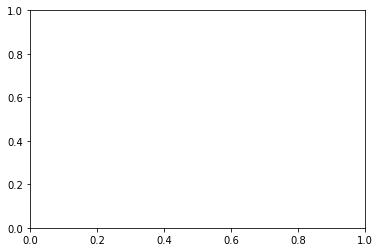

In [ ]:
pca = PCA(n_components=2)
Xreduced = pca.fit_transform(transformation.toarray())
print('xred', Xreduced)
clf = SVC(kernel=cosine_similarity, C=1)
clf.fit(Xreduced, y_train)
fig, ax = plt.subplots()

# title for the plots
title = ('Decision surface of cosine similarity SVC ')
# Set-up grid for plotting.
X0, X1 = Xreduced[:, 0], Xreduced[:, 1]
# xx, yy = make_meshgrid(X0, X1)

plot_surface(clf, X0, X1, ax, contourf=True, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('Decison surface using the PCA transformed/projected features')
ax.legend()
plt.show()


In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from numpy.linalg import norm

In [17]:
text_tfidf = TfidfVectorizer(
    min_df=1,  # min count for relevant vocabulary
    strip_accents='unicode',  # replace all accented unicode char 
    # by their corresponding  ASCII char
    analyzer='word',  # features made of words
    token_pattern=r'\w{1,}',  # tokenize only words of 4+ chars
    ngram_range=(1, 1),  # features made of a single tokens
    use_idf=True,  # enable inverse-document-frequency reweighting
    smooth_idf=True,  # prevents zero division for unseen words
    sublinear_tf=False
)
text = text_tfidf.fit_transform([
    # 'chemistry: concept application, student edition',
    'theory development concept application',
    'history civilization',
    'river run'
])
text.toarray()

array([[0.5       , 0.        , 0.5       , 0.5       , 0.        ,
        0.        , 0.        , 0.5       ],
       [0.        , 0.70710678, 0.        , 0.        , 0.70710678,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.70710678, 0.70710678, 0.        ]])

In [23]:
check = text_tfidf.transform(['chemistry concept application student edition'])
check.toarray()

array([[0.70710678, 0.        , 0.70710678, 0.        , 0.        ,
        0.        , 0.        , 0.        ]])

In [ ]:
test = [
    'chemistry: concept application, student edition'
]
train = [
    'theory development concept application',
    'history civilization',
    'river run'
]

label = [
    'sains-tech',
    'social-humanaria',
    'general'
]
train_tfidf_result = [
   [0.43779123, 0, 0, 0.43779123, 0.55528266, 0, 0, 0, 0, 0, 0.55528266],
   [0, 0, 0.70710678, 0, 0, 0, 0.70710678, 0, 0, 0,0],
   [0, 0, 0, 0, 0, 0, 0, 0.70710678, 0.70710678, 0, 0]
]
test_tfidf_result = [[0.38274272, 0.48546061, 0, 0.38274272, 0, 0.48546061, 0, 0, 0, 0.48546061, 0]]

In [ ]:
mdl = SVC(kernel=cosine_similarity, C=1)
mdl.fit(train_tfidf_result, label)

SVC(C=1, kernel=<function cosine_similarity at 0x0000013B4F4F9D90>)

In [28]:
data = [
   [0.477, 0.477, 0.477, 0, 0, 0, 0.477, 0],
   [0, 0, 0, 0.477, 0.477, 0, 0, 0],
   [0, 0, 0, 0, 0, 0.477, 0, 0.477]
]
masukkan = [0, 0.6, 0.6, 0, 0, 0, 0, 0]

In [31]:
xz = np.dot(data,masukkan)/(norm(data, axis=1)*norm(masukkan))
xz

array([0.70710678, 0.        , 0.        ])